In [ ]:
import os
import re
import cv2
import tarfile
import datetime
import warnings
import prettytable
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow import concat
from tensorflow import repeat
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
from prettytable import PrettyTable
from skimage.transform import resize
import nltk.translate.bleu_score as bleu
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import expand_dims
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import concatenate, Concatenate
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Layer, Dropout, GRU

In [ ]:
image_model = DenseNet121(weights='/content/drive/MyDrive/Major_Project/Model/brucechou1983_CheXNet_Keras_0.3.0_weights.h5', classes = 14, input_shape=(256,256,3))

In [ ]:
model = Model(image_model.input, image_model.layers[-2].output)

In [ ]:
train = np.load('/content/drive/MyDrive/Major_Project/Data/train.npy',allow_pickle=True)
test = np.load('/content/drive/MyDrive/Major_Project/Data/test.npy',allow_pickle=True)
validation = np.load('/content/drive/MyDrive/Major_Project/Data/validation.npy',allow_pickle=True)

In [ ]:
columns = ["front X-Ray", "lateral X-Ray", "findings", "dec_ip", "dec_op", "image_features"]

train = pd.DataFrame(train, columns = columns)
test = pd.DataFrame(test, columns = columns)
validation = pd.DataFrame(validation, columns = columns)

In [ ]:
print("train data -     ",train.shape)
print('test data -      ',test.shape)
print('validation data -',validation.shape)

train data -      (3200, 6)
test data -       (399, 6)
validation data - (350, 6)


In [ ]:
train.head()

,front X-Ray,lateral X-Ray,findings,dec_ip,dec_op,image_features
0,CXR167_IM-0441-1001.png,CXR167_IM-0441-1002.png,<start> both lungs are clear and expanded an o...,<start> both lungs are clear and expanded an o...,both lungs are clear and expanded an old calci...,"[[5.7280434702988714e-05, 0.001676254905760288..."
1,CXR2561_IM-1064-1001.png,CXR2561_IM-1064-1001.png,<start> lungs are clear bilaterally cardiac an...,<start> lungs are clear bilaterally cardiac an...,lungs are clear bilaterally cardiac and medias...,"[[2.7444737497717142e-05, 0.001650683116167783..."
2,CXR2592_IM-1084-2001.png,CXR2592_IM-1084-1001.png,<start> the lungs are clear there is no pleura...,<start> the lungs are clear there is no pleura...,the lungs are clear there is no pleural effusi...,"[[0.00013672266504727304, 0.001249730121344328..."
3,CXR218_IM-0792-0001.png,CXR218_IM-0792-4004.png,<start> heart size is unchanged aortic calcifi...,<start> heart size is unchanged aortic calcifi...,heart size is unchanged aortic calcification i...,"[[4.9161011702381074e-05, 0.001062895520590245..."
4,CXR55_IM-2154-2001.png,CXR55_IM-2154-1001.png,<start> lung lines remain low however no focal...,<start> lung lines remain low however no focal...,lung lines remain low however no focal infiltr...,"[[0.0, 0.0013188612647354603, 0.00152136199176..."


In [ ]:
token = Tokenizer( filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n')
token.fit_on_texts(train['findings'])

token.word_index['<pad>'] = 0
token.index_word[0] = '<pad>'
vocab_size = len(token.word_index) + 1
print('Vocab size - ', vocab_size)

#sequence in train and validation
train_inp_dec = token.texts_to_sequences(train.dec_ip)
train_op_dec = token.texts_to_sequences(train.dec_op)
val_inp_dec = token.texts_to_sequences(validation.dec_ip)
val_op_dec = token.texts_to_sequences(validation.dec_op)

#padding in the train and validation
max_len = 100
decoder_input = pad_sequences(train_inp_dec, maxlen=max_len, padding='post')
decoder_output =  pad_sequences(train_op_dec, maxlen=max_len, padding='post')
Validation_decoder_input = pad_sequences(val_inp_dec, maxlen=max_len, padding='post')
Validation_decoder_output = pad_sequences(val_op_dec, maxlen=max_len, padding='post')
print(decoder_input[:1])

word_idx = {}
idx_word = {}
for key, value in (token.word_index).items():
    word_idx[key] = value
    idx_word[value] = key

Vocab size -  1447
[[  5  99  16   4  20   8 103 143 214  55  87   3  79  22   1  29  62  70
   15   8  38   7   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]


# New one

### Writing Encoder :

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self,lstm_units):
        super().__init__()

        self.lstm_units = lstm_units
        self.dense      = Dense(self.lstm_units, kernel_initializer="glorot_uniform", name = 'encoder_dense_layer')

    def initialize_states(self,batch_size):

      self.batch_size  = batch_size
      self.enc_h       = tf.zeros((self.batch_size, self.lstm_units))

      return self.enc_h

    def call(self,x):

      # x : image_data
      encoder_output = self.dense(x)

      return encoder_output

## Writing Attention :

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class that calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,attention_units):
    super().__init__()

    self.attention_units = attention_units

    self.w1_Dense    =  tf.keras.layers.Dense(self.attention_units, kernel_initializer="glorot_uniform", name='Concat_w1_Dense')
    self.w2_Dense    =  tf.keras.layers.Dense(self.attention_units, kernel_initializer="glorot_uniform", name='Concat_w2_Dense')
    self.Concat_Dense=  tf.keras.layers.Dense(1, kernel_initializer="glorot_uniform", name = 'Concat_Dense_layer')

  def call(self,x):

    self.decoder_hidden_state, self.encoder_output = x
    self.decoder_hidden_state = tf.expand_dims(self.decoder_hidden_state,axis = 1)

    score = self.Concat_Dense(tf.nn.tanh(self.w1_Dense(self.decoder_hidden_state) + self.w2_Dense(self.encoder_output)))

    att_weights    = tf.nn.softmax(score, axis=1)
    context_vector = att_weights * self.encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector,att_weights

## Writing Onestepdecoder :

In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units):
      super().__init__()

      self.lstm_units     = lstm_units
      self.vocab_size     = vocab_size
      self.embedding_dim  = embedding_dim
      self.attention_units= attention_units

      self.dense       = Dense(self.vocab_size, kernel_initializer="glorot_uniform", name ='onestep_dense')
      self.attention   = Attention( self.attention_units)
      self.decoder_emb = Embedding(self.vocab_size, self.embedding_dim, trainable = True , name = 'Decoder_embedding')
      self.decoder_gru = GRU(self.lstm_units, return_state=True, return_sequences=True, name="Decoder_LSTM")


      self.dropout1 = Dropout(0.3,name = 'dropout1')
      self.dropout2 = Dropout(0.3,name = 'dropout2')
      self.dropout3 = Dropout(0.3,name = 'dropout3')

  @tf.function
  def call(self,x,training=None):

    self.input_to_decoder, self.encoder_output, self.state_h = x

    embedded_output = self.decoder_emb(self.input_to_decoder)
    embedded_output = self.dropout1(embedded_output)

    y = [self.state_h,self.encoder_output]
    context_vector, att_weights = self.attention(y)

    concated_decoder_input = tf.concat([tf.expand_dims(context_vector, 1),embedded_output], -1)
    concated_decoder_input = self.dropout2(concated_decoder_input)

    output_gru, hidden_state = self.decoder_gru(concated_decoder_input, initial_state=self.state_h)

    output_gru = tf.reshape(output_gru, (-1, output_gru.shape[2]))
    output_gru = self.dropout3(output_gru)

    output = self.dense(output_gru)

    return output,hidden_state,att_weights,context_vector

## Writing Decoder :

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units):
      super().__init__()

      self.lstm_units     = lstm_units
      self.vocab_size     = vocab_size
      self.embedding_dim  = embedding_dim
      self.attention_units= attention_units

      self.onestepdecoder = OneStepDecoder(self.vocab_size, self.embedding_dim, self.lstm_units, self.attention_units)

    @tf.function
    def call(self, x,training=None):

        self.input_to_decoder, self.encoder_output, self.decoder_hidden_state = x
        all_outputs = tf.TensorArray(tf.float32,size = self.input_to_decoder.shape[1], name = 'output_arrays' )

        for timestep in tf.range(self.input_to_decoder.shape[1]):

          y = [self.input_to_decoder[:,timestep:timestep+1],self.encoder_output, self.decoder_hidden_state]
          output,hidden_state,att_weights,context_vector = self.onestepdecoder(y)

          self.decoder_hidden_state = hidden_state
          all_outputs = all_outputs.write(timestep,output)

        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])

        return all_outputs

## Encoder-Decoder Model :

In [ ]:
class Encoder_decoder(tf.keras.Model):
  """
     # Intialize encoder states, Pass the encoder_sequence to the embedding layer
     # Decoder initial states are encoder final states, Initialize it accordingly
     # Pass the decoder sequence,encoder_output,decoder states to Decoder
     # return the decoder output

  """
  def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units, batch_size):
        super().__init__()

        self.vocab_size     = vocab_size
        self.batch_size     = batch_size
        self.lstm_units     = lstm_units
        self.embedding_dim  = embedding_dim
        self.attention_units= attention_units

        self.encoder = Encoder(self.lstm_units)
        self.decoder = Decoder(vocab_size, embedding_dim, lstm_units, attention_units)
        self.dense   = Dense(self.vocab_size, kernel_initializer="glorot_uniform", name = 'enc_dec_dense')



  def call(self,data):

    self.inputs, self.outputs = data[0], data[1]

    self.encoder_hidden = self.encoder.initialize_states(self.batch_size)
    self.encoder_output = self.encoder(self.inputs)

    x = [self.outputs,self.encoder_output,self.encoder_hidden]
    output = self.decoder(x)

    return output

## Writing Custom loss function :

---



In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

**Load Encoder-Decoder Model :**

In [ ]:
lstm_units     = 256
batch_size     = 50
Buffer_size    = 500
embedding_dim  = 300
attention_units = 64

In [ ]:
tf.keras.backend.clear_session()
#This will clear all tensorflow session
Attention_model = Encoder_decoder(vocab_size,embedding_dim,lstm_units,attention_units,batch_size)
Attention_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=loss_function)

In [ ]:
# sequence_length =   # Set this to the correct sequence length used in training

# # Clear session
# tf.keras.backend.clear_session()

# # Rebuild the model
# Attention_model = Encoder_decoder(vocab_size, embedding_dim, lstm_units, attention_units, batch_size)

# # Manually build the model with the correct input shape
# Attention_model.build(input_shape=(batch_size, sequence_length))

# # Now load the saved weights
# Attention_model.load_weights("drive/My Drive/Attention_modelv1.weights.h5")

**CallBacks** :

In [ ]:
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience = 10, baseline=None, verbose = 1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min',verbose = 1, patience=5, min_lr=0.000001)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

**Create Datasets :**

In [ ]:
# Reshaping the image feature tensors for training
train_image_features = np.vstack(train.image_features).astype(np.float64)
validation_image_features = np.vstack(validation.image_features).astype(np.float64)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(((train_image_features, decoder_input), decoder_output))
train_dataset = train_dataset.shuffle(Buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_image_features,Validation_decoder_input),Validation_decoder_output))
validation_dataset = validation_dataset.shuffle(Buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**Model-training :**

In [ ]:
history = Attention_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stop, reduce_lr, tensorboard],
    shuffle=True
)

Epoch 1/100
64/64 [==============================] - 156s 2s/step - loss: 1.4243 - val_loss: 1.3873 - lr: 0.0010
Epoch 2/100
64/64 [==============================] - 140s 2s/step - loss: 1.3502 - val_loss: 1.3577 - lr: 0.0010
Epoch 3/100
64/64 [==============================] - 147s 2s/step - loss: 1.3066 - val_loss: 1.2992 - lr: 0.0010
Epoch 4/100
64/64 [==============================] - 144s 2s/step - loss: 1.2326 - val_loss: 1.1795 - lr: 0.0010
Epoch 5/100
64/64 [==============================] - 140s 2s/step - loss: 1.0471 - val_loss: 0.9331 - lr: 0.0010
Epoch 6/100
64/64 [==============================] - 149s 2s/step - loss: 0.8366 - val_loss: 0.7878 - lr: 0.0010
Epoch 7/100
64/64 [==============================] - 151s 2s/step - loss: 0.7314 - val_loss: 0.7180 - lr: 0.0010
Epoch 8/100
64/64 [==============================] - 145s 2s/step - loss: 0.6718 - val_loss: 0.6726 - lr: 0.0010
Epoch 9/100
64/64 [==============================] - 142s 2s/step - loss: 0.6286 - val_loss: 0.6

In [ ]:
# Attention_model.fit(train_dataset, validation_data=validation_dataset, epochs=20, callbacks=[early_stop,reduce_lr,tensorboard], shuffle=True)

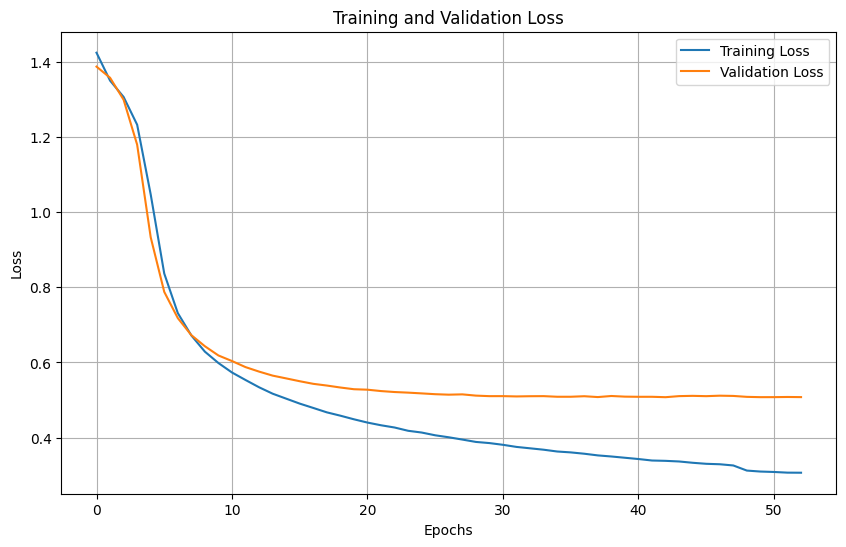

In [ ]:
# Extract training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
Attention_model.save_weights('Attention_model03.h5')
!cp Attention_model03.h5 "drive/My Drive/"

In [ ]:
# Attention_model = keras.models.load_model("/content/Attention_model")

In [ ]:
# sequence_length = 50  # Set this to the correct sequence length used in training

# # Clear session
# tf.keras.backend.clear_session()

# # Rebuild the model
# Attention_model = Encoder_decoder(vocab_size, embedding_dim, lstm_units, attention_units, batch_size)

# # # Manually build the model with the correct input shape
# # Attention_model.build(input_shape=(batch_size, sequence_length))

# # Now load the saved weights
# Attention_model.load_weights("/content/Attention_modelb1.weights.h5")

In [ ]:
# # Recreate the model architecture
# Attention_model = Encoder_decoder(vocab_size, embedding_dim, lstm_units, attention_units, batch_size)

# # Manually build the model with a flexible input shape
# Attention_model.build(input_shape=(batch_size, None))  # No need for fixed sequence length

# # Now load the weights
# Attention_model.load_weights("drive/My Drive/Attention_modelv1.weights.h5")

In [ ]:
def load_image(img_name):
  """Loads image in array format"""

  image = Image.open(img_name)
  X = np.asarray(image.convert("RGB"))
  X = np.asarray(X)
  X = preprocess_input(X)
  X = resize(X, (256,256,3))
  X = np.expand_dims(X, axis=0)
  X = np.asarray(X)

  return X

In [ ]:
def preprocess(image1_paths,image2_paths):

  '''
    input -- dataframe(df)
    output -- dataframe(df)
    process - convert images into 256 X 256, then using CHeXNET model generate tensor(concate two image tensor)

  '''
  print("path1;-",image1_paths)
  print("path1;-",image2_paths)
  path = '/content/drive/MyDrive/NLMCXR_images/'
  image_features = []
  for i in range(len(image1_paths)):

    i1 = load_image(path+image1_paths)
    i2 = load_image(path+image2_paths)
    img1_features = model.predict(i1)
    img2_features = model.predict(i2)
    img1_features = np.vstack(img1_features).astype(np.float64)
    img2_features = np.vstack(img2_features).astype(np.float64)

    tensor = np.concatenate((img1_features, img2_features), axis=1)

  return tensor

In [ ]:
#Refrence : https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/

def evaluate(image1, image2):
    '''
    Input - two image and image path
    output - return medical report of the images
    This function takes images and using encoder decoder model
    return medical report of the images
    The function predicts the sentence using beam search

    '''
    img_tensor     = preprocess(image1, image2)
    image_features = np.vstack(img_tensor).astype(np.float64)

    result = ''
    initial_state = Attention_model.layers[0].initialize_states(1)
    sequences     = [['<start>', initial_state, 0]]

    encoder_output       = Attention_model.layers[0](image_features)
    decoder_hidden_state = initial_state

    max_len = 75
    beam_width = 3
    finished_seq = []

    for i in range(max_len):#traverse through all lengths
        new_seq = [] #stores the seq which does not have <end> in them
        all_probable = [] #stores all the top k seq along with their scores

        for seq,state,score in sequences: #traverse for all top k sequences

            cur_vec = np.reshape(word_idx[seq.split(" ")[-1]],(1,1))
            decoder_hidden_state = state
            x = [cur_vec, encoder_output, decoder_hidden_state]
            output,hidden_state,att_weights,context_vector = Attention_model.get_layer('decoder').onestepdecoder(x)
            output = tf.nn.softmax(output)
            top_words = np.argsort(output).flatten()[-beam_width:] #get the top k words
            for index in top_words:
                #here we will update score with log of probabilities and subtracting(log of prob will be in negative)
                #here since its -(log), lower the score higher the prob
                predicted = [seq + ' '+ idx_word[index], hidden_state, score-np.log(np.array(output).flatten()[index])] #updating the score and seq
                all_probable.append(predicted)

        sequences = sorted(all_probable, key = lambda l: l[2])[:beam_width] #getting the top 3 sentences with high prob ie low score

        count = 0
        for seq,state,score in sequences: #check for 'endseq' in each seq in the beam
            if seq.split(" ")[-1] == '<end>': #if last word of the seq is <end>
                score = score/len(seq) #normalizing
                finished_seq.append([seq,state,score])
                count+=1
            else:
                new_seq.append([seq,state,score])

        sequences = new_seq
        beam_width= beam_width - count #substracting the no. of finished sentences from beam length

        if not sequences: #if all the sequences reaches its end
            break
        else:
            continue

    if len(finished_seq) >0:
          finished_seq = sorted(finished_seq, reverse=True, key = lambda l: l[2])
          sequences = finished_seq[-1] #getting the last predicted output with least probablity score.
          k=0# Reverse Sorted the Predicted output by score measure
          for i in finished_seq:
            k+=1
            print('Beam probablity-',i[2],'Candidate',k,':',i[0]) #printing top k predicted sentence by beam serch and their probablity score
          return sequences[0]
    else:
          return new_seq[-1][0]

In [ ]:
# def test_img_cap(img_data):

#     '''
#     input - imagedata point contain two x ray image and acutal medical report of the images
#     output - function return two images and its original and predical medical report
#     also return bleu score of the context

#     '''
#     path = '/content/images/'

#     fig, axs = plt.subplots(1, 2, figsize = (10,10), tight_layout=True)
#     count = 0
#     for img, subplot in zip(img_data[:2], axs.flatten()):
#         img_= mpimg.imread(path+img)
#         imgplot = axs[count].imshow(img_, cmap = 'bone')
#         count +=1
#     plt.show()

#     print('Acutal Report :', img_data[2])
#     print('*'*200)
#     result = evaluate(img_data[0],img_data[1])
#     print('*'*200)
#     print("Best Predicted:",result)
#     print('BLEU Score :-',sentence_bleu(img_data[2], result),'\n')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from nltk.translate.bleu_score import sentence_bleu

def test_img_cap(img_data):
    '''
    input - img_data contains two x-ray images and the actual medical report of the images
    output - function returns two images, their original and predicted medical reports
    and also returns the BLEU score of the context
    '''
    path = '/content/drive/MyDrive/NLMCXR_images/'

    fig, axs = plt.subplots(1, 2, figsize=(10, 10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axs.flatten()):
        img_ = mpimg.imread(path + img)
        axs[count].imshow(img_, cmap='bone')
        count += 1
    plt.show()

    # Actual report from img_data[2]
    actual_report = img_data[2]
    print('Actual Report:', actual_report)
    print('*' * 200)

    # Generate the predicted report using the evaluate function
    result = evaluate(img_data[0], img_data[1])
    print('*' * 200)
    print("Best Predicted:", result)

    # Tokenize both actual and predicted reports
    actual_tokens = actual_report.lower().split()  # Tokenize actual report
    predicted_tokens = result.lower().split()      # Tokenize predicted report

    # Calculate BLEU-1 (1-gram BLEU score)
    bleu_score = sentence_bleu([actual_tokens], predicted_tokens, weights=(1, 0, 0, 0))

    print('BLEU Score:', bleu_score, '\n')

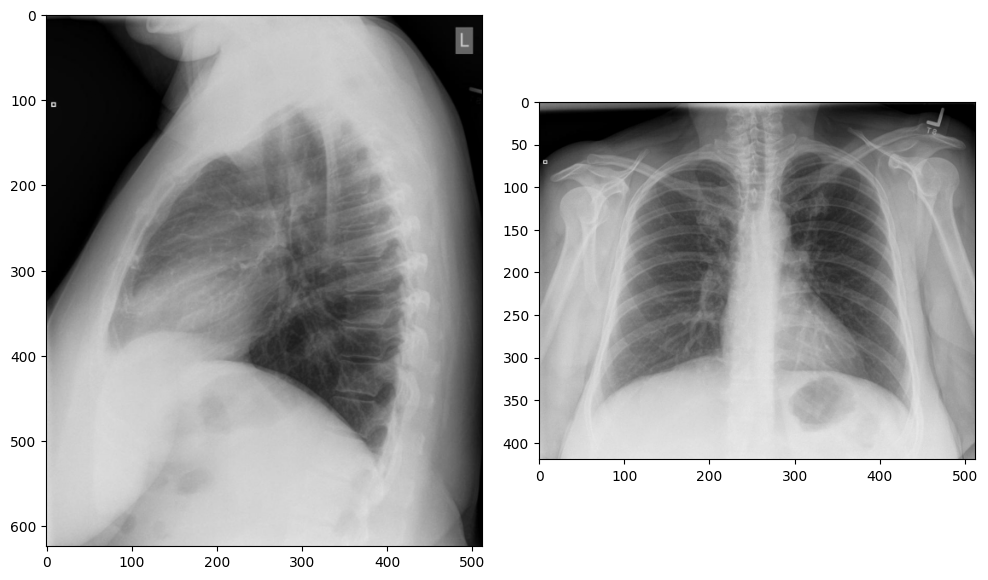

Actual Report: <start> the heart size and pulmonary vascularity appear within normal limits the lungs are free of focal airspace disease no pleural effusion or pneumothorax is seen <end>
********************************************************************************************************************************************************************************************************
path1;- CXR222_IM-0823-3003.png
path1;- CXR222_IM-0823-1001.png
1/1 [==============================] - 0s 209ms/step
Beam probablity- 0.10558314107358456 Candidate 1 : <start> no findings <end>
Beam probablity- 0.041150806063983573 Candidate 2 : <start> the heart size and pulmonary vascularity appear within normal limits the lungs are free of focal airspace disease no pleural effusion or pneumothorax is seen degenerative changes are present in the spine <end>
Beam probablity- 0.039659538382544504 Candidate 3 : <start> the heart size and pulmonary vascularity appear within normal limits the lungs are free 

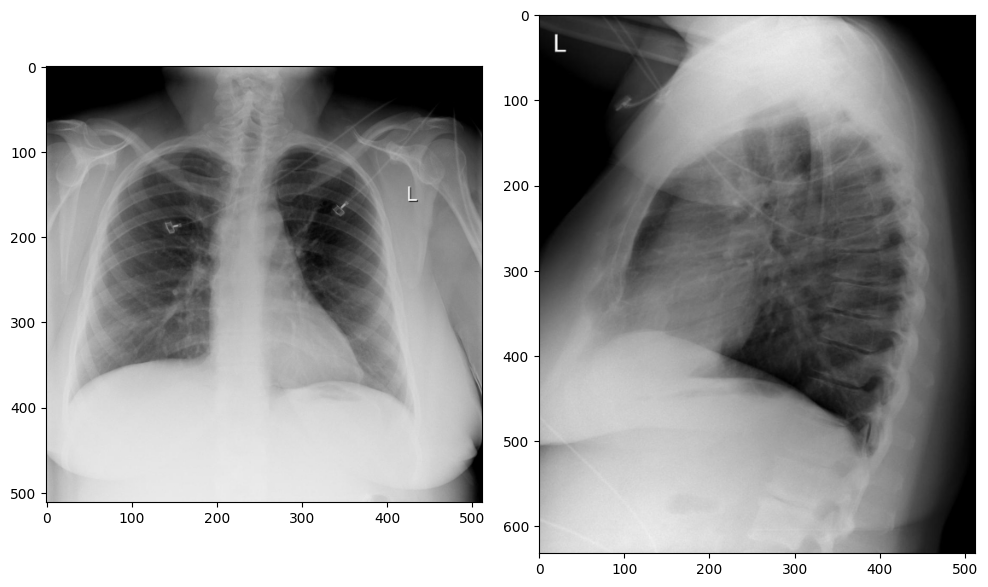

Actual Report: <start> the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size the lungs are clear of focal airspace disease pneumothorax or pleural effusion there are no acute bony findings <end>
********************************************************************************************************************************************************************************************************
path1;- CXR2612_IM-1103-1001.png
path1;- CXR2612_IM-1103-2001.png
1/1 [==============================] - 0s 226ms/step
Beam probablity- 0.057162998797387905 Candidate 1 : <start> the lungs are clear there is no focal airspace consolidation no pleural effusion or pneumothorax the heart and pulmonary are normal the cardiomediastinal silhouette is within normal limits there is no acute bony findings <end>
Beam probablity- 0.05698540349827802 Candidate 2 : <start> the lungs are clear there is no focal airspace consolidation no pleural effusion or pneumothorax the 

In [ ]:
for i in test.values[10:12]:
    test_img_cap(i)